## Overview

In [1]:
from langgraph.graph import StateGraph, MessagesState, START, END

def mock_llm(state: MessagesState):
    return{"messages" : [{"role": "ai", "content": "hello world"}]}

graph = StateGraph(MessagesState)
graph.add_node(mock_llm)
graph.add_edge(START, "mock_llm")
graph.add_edge("mock_llm", END)

graph = graph.compile()

graph.invoke({"messages": [{"role": "user", "content": "Hi"}]})

{'messages': [HumanMessage(content='Hi', additional_kwargs={}, response_metadata={}, id='80a8bc64-ddd0-4b8d-8f43-8a9612254a19'),
  AIMessage(content='hello world', additional_kwargs={}, response_metadata={}, id='4c173fc0-8dc4-4edd-a577-f54ffb3fbbd7', tool_calls=[], invalid_tool_calls=[])]}

## Agents

In [1]:
## Defining Tools

from langchain.tools import tool
from langchain.chat_models import init_chat_model


model = init_chat_model(
    model="gpt-4.1",
    temperature=0
)


# Define tools
@tool
def multiply(a: int, b: int) -> int:
    """Multiply `a` and `b`.

    Args:
        a: First int
        b: Second int
    """
    return a * b


@tool
def add(a: int, b: int) -> int:
    """Adds `a` and `b`.

    Args:
        a: First int
        b: Second int
    """
    return a + b


@tool
def divide(a: int, b: int) -> float:
    """Divide `a` and `b`.

    Args:
        a: First int
        b: Second int
    """
    return a / b


# Augment the LLM with tools
tools = [add, multiply, divide]
tools_by_name = {tool.name: tool for tool in tools}
model_with_tools = model.bind_tools(tools)

In [2]:
## State defining

from langchain.messages import AnyMessage
from typing_extensions import TypedDict, Annotated
import operator


class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]
    llm_calls: int


In [3]:
## Define model node

from langchain.messages import SystemMessage


def llm_call(state: dict):
    """LLM decides whether to call a tool or not"""

    return {
        "messages": [
            model_with_tools.invoke(
                [
                    SystemMessage(
                        content="You are a helpful assistant tasked with performing arithmetic on a set of inputs."
                    )
                ]
                + state["messages"]
            )
        ],
        "llm_calls": state.get('llm_calls', 0) + 1
    }

In [4]:
## define tool node

from langchain.messages import ToolMessage


def tool_node(state: dict):
    """Performs the tool call"""

    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": result}

In [5]:
## Define end logic

from typing import Literal
from langgraph.graph import StateGraph, START, END


def should_continue(state: MessagesState) -> Literal["tool_node", END]:
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call"""

    messages = state["messages"]
    last_message = messages[-1]

    # If the LLM makes a tool call, then perform an action
    if last_message.tool_calls:
        return "tool_node"

    # Otherwise, we stop (reply to the user)
    return END

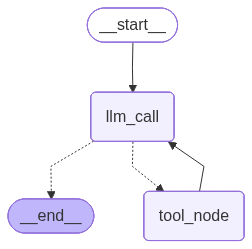

In [ ]:
# Build workflow
agent_builder = StateGraph(MessagesState)

# Add nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("tool_node", tool_node)

# Add edges to connect nodes
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    ["tool_node", END]
)
agent_builder.add_edge("tool_node", "llm_call")

# Compile the agent
agent = agent_builder.compile()

# Show the agent
from IPython.display import Image, display
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

# Invoke
from langchain.messages import HumanMessage
messages = [HumanMessage(content="Add 3 and 4.")]
messages = agent.invoke({"messages": messages})

In [8]:
for i in messages['messages']:
    i.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (call_cXu3O0gJsnhkIRdneuQVOw9P)
 Call ID: call_cXu3O0gJsnhkIRdneuQVOw9P
  Args:
    a: 3
    b: 4
================================= Tool Message =================================

7
================================== Ai Message ==================================

3 plus 4 equals 7.


In [9]:
messages['messages'][1].response_metadata

{'token_usage': {'completion_tokens': 17,
  'prompt_tokens': 162,
  'total_tokens': 179,
  'completion_tokens_details': {'accepted_prediction_tokens': 0,
   'audio_tokens': 0,
   'reasoning_tokens': 0,
   'rejected_prediction_tokens': 0},
  'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}},
 'model_provider': 'openai',
 'model_name': 'gpt-4.1-2025-04-14',
 'system_fingerprint': 'fp_1a2c4a5ede',
 'id': 'chatcmpl-CxpAs97YYbEuTSOLwjJJ73wL7i1Ds',
 'service_tier': 'default',
 'finish_reason': 'tool_calls',
 'logprobs': None}

In [40]:
messages['messages'][1].id

'lc_run--019bb30d-8717-7e32-beaf-d1d1129bcb60-0'

In [42]:
messages['messages'][1].tool_calls

[{'name': 'add',
  'args': {'a': 3, 'b': 4},
  'id': 'call_MNKLhI33pWQobDjZ0BTYSpr4',
  'type': 'tool_call'}]

In [46]:
messages['messages'][1].usage_metadata

{'input_tokens': 162,
 'output_tokens': 17,
 'total_tokens': 179,
 'input_token_details': {'audio': 0, 'cache_read': 0},
 'output_token_details': {'audio': 0, 'reasoning': 0}}

In [47]:
messages['messages'][1]

AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 162, 'total_tokens': 179, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4.1-2025-04-14', 'system_fingerprint': 'fp_1a2c4a5ede', 'id': 'chatcmpl-CxF8RUjU7CFcz1882yYcE743VNrw0', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019bb30d-8717-7e32-beaf-d1d1129bcb60-0', tool_calls=[{'name': 'add', 'args': {'a': 3, 'b': 4}, 'id': 'call_MNKLhI33pWQobDjZ0BTYSpr4', 'type': 'tool_call'}], invalid_tool_calls=[], usage_metadata={'input_tokens': 162, 'output_tokens': 17, 'total_tokens': 179, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

## Thinking in LangGraph

The agent should:

- Read incoming customer emails
- Classify them by urgency and topic
- Search relevant documentation to answer questions
- Draft appropriate responses
- Escalate complex issues to human agents
- Schedule follow-ups when needed

Example scenarios to handle:

1. Simple product question: "How do I reset my password?"
2. Bug report: "The export feature crashes when I select PDF format"
3. Urgent billing issue: "I was charged twice for my subscription!"
4. Feature request: "Can you add dark mode to the mobile app?"
5. Complex technical issue: "Our API integration fails intermittently with 504 errors"

In [2]:
from typing import TypedDict, Literal

# Define the structure for email classification
class EmailClassification(TypedDict):
    intent: Literal["question", "bug", "billing", "feature", "complex"]
    urgency: Literal["low", "medium", "high", "critical"]
    topic: str
    summary: str

class EmailAgentState(TypedDict):
    # Raw email data
    email_content: str
    sender_email: str
    email_id: str

    # Classification result
    classification: EmailClassification | None

    # Raw search/API results
    search_results: list[str] | None  # List of raw document chunks
    customer_history: dict | None  # Raw customer data from CRM

    # Generated content
    draft_response: str | None
    messages: list[str] | None

In [ ]:
## Read and classify email
import stat
from turtle import goto
from typing import Literal
from langgraph.graph import StateGraph, START, END
from langgraph.types import interrupt, Command, RetryPolicy
from langchain_openai import ChatOpenAI
from langchain.messages import HumanMessage


llm = ChatOpenAI(model="gpt-4.1", temperature=0)

def read_email(state: EmailAgentState) -> dict:
    """Extract and parse email content"""
    # In production, this would connect to your email service
    return {
        "messages": [HumanMessage(content=f"Processing email: {state['email_content']}")]
    }

def classify_intent(state: EmailAgentState) -> Command[Literal["search_documentation", "human_review", "draft_response", "bug_tracking"]]:
    """Use LLM to classify email intent and urgency, then route accordingly"""

    # Create structured LLM that returns EmailClassification dict
    structured_llm = llm.with_structured_output(EmailClassification)

    # Format the prompt on-demand, not stored in state
    classification_prompt = f"""
    Analyze this customer email and classify it:

    Email: {state['email_content']}
    From: {state['sender_email']}

    Provide classification including intent, urgency, topic, and summary.
    """

    # Get structured response directly as dict
    classification = structured_llm.invoke(classification_prompt)

    # Determine next node based on classification
    if classification['intent'] == 'billing' or classification['urgency'] == 'critical':
        goto = "human_review"
    elif classification['intent'] in ['question', 'feature']:
        goto = "search_documentation"
    elif classification['intent'] == 'bug':
        goto = "bug_tracking"
    else:
        goto = "draft_response"

    # Store classification as a single dict in state
    return Command(
        update={"classification": classification},
        goto=goto
    )

In [4]:
def search_documentation(state: EmailAgentState) -> Command[Literal["draft_response"]]:
    """Search knowledge base for relevant information"""

    # Build search query from classification
    classification = state.get('classification', {})
    query = f"{classification.get('intent', '')} {classification.get('topic', '')}"

    try:
        # Implement your search logic here
        # Store raw search results, not formatted text
        search_results = [
            "Reset password via Settings > Security > Change Password",
            "Password must be at least 12 characters",
            "Include uppercase, lowercase, numbers, and symbols"
        ]
    except Exception as e:
        # For recoverable search errors, store error and continue
        search_results = [f"Search temporarily unavailable: {str(e)}"]

    return Command(
        update={"search_results": search_results},  # Store raw results or error
        goto="draft_response"
    )

def bug_tracking(state: EmailAgentState) -> Command[Literal["draft_response"]]:
    """Create or update bug tracking ticket"""

    # Create ticket in your bug tracking system
    ticket_id = "BUG-12345"  # Would be created via API

    return Command(
        update={
            "search_results": [f"Bug ticket {ticket_id} created"],
            "current_step": "bug_tracked"
        },
        goto="draft_response"
    )

In [5]:
def draft_response(state: EmailAgentState) -> Command[Literal["human_review", "send_reply"]]:
    """Generate response using context and route based on quality"""

    classification = state.get('classification', {})

    # Format context from raw state data on-demand
    context_sections = []

    if state.get('search_results'):
        # Format search results for the prompt
        formatted_docs = "\n".join([f"- {doc}" for doc in state['search_results']])
        context_sections.append(f"Relevant documentation:\n{formatted_docs}")

    if state.get('customer_history'):
        # Format customer data for the prompt
        context_sections.append(f"Customer tier: {state['customer_history'].get('tier', 'standard')}")

    # Build the prompt with formatted context
    draft_prompt = f"""
    Draft a response to this customer email:
    {state['email_content']}

    Email intent: {classification.get('intent', 'unknown')}
    Urgency level: {classification.get('urgency', 'medium')}

    {chr(10).join(context_sections)}

    Guidelines:
    - Be professional and helpful
    - Address their specific concern
    - Use the provided documentation when relevant
    """

    response = llm.invoke(draft_prompt)

    # Determine if human review needed based on urgency and intent
    needs_review = (
        classification.get('urgency') in ['high', 'critical'] or
        classification.get('intent') == 'complex'
    )

    # Route to appropriate next node
    goto = "human_review" if needs_review else "send_reply"

    return Command(
        update={"draft_response": response.content},  # Store only the raw response
        goto=goto
    )

def human_review(state: EmailAgentState) -> Command[Literal["send_reply", END]]:
    """Pause for human review using interrupt and route based on decision"""

    classification = state.get('classification', {})

    # interrupt() must come first - any code before it will re-run on resume
    human_decision = interrupt({
        "email_id": state.get('email_id',''),
        "original_email": state.get('email_content',''),
        "draft_response": state.get('draft_response',''),
        "urgency": classification.get('urgency'),
        "intent": classification.get('intent'),
        "action": "Please review and approve/edit this response"
    })

    # Now process the human's decision
    if human_decision.get("approved"):
        return Command(
            update={"draft_response": human_decision.get("edited_response", state.get('draft_response',''))},
            goto="send_reply"
        )
    else:
        # Rejection means human will handle directly
        return Command(update={}, goto=END)

def send_reply(state: EmailAgentState) -> dict:
    """Send the email response"""
    # Integrate with email service
    print(f"Sending reply: {state['draft_response'][:100]}...")
    return {}

In [ ]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.types import RetryPolicy

# Create the graph
workflow = StateGraph(EmailAgentState)

# Add nodes with appropriate error handling
workflow.add_node("read_email", read_email)
workflow.add_node("classify_intent", classify_intent)

# Add retry policy for nodes that might have transient failures
workflow.add_node(
    "search_documentation",
    search_documentation,
    retry_policy=RetryPolicy(max_attempts=3)
)
workflow.add_node("bug_tracking", bug_tracking)
workflow.add_node("draft_response", draft_response)
workflow.add_node("human_review", human_review)
workflow.add_node("send_reply", send_reply)

# Add only the essential edges
workflow.add_edge(START, "read_email")
workflow.add_edge("read_email", "classify_intent")
workflow.add_edge("send_reply", END)

# Compile with checkpointer for persistence, in case run graph with Local_Server --> Please compile without checkpointer
memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

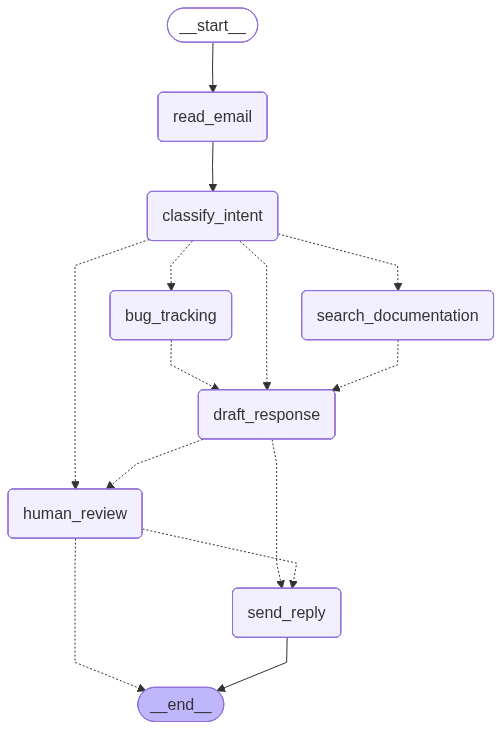

In [27]:
# Show the agent
from IPython.display import Image, display
display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
# Test with an urgent billing issue
initial_state = {
    "email_content": "I was charged twice for my subscription! This is urgent!",
    "sender_email": "customer@example.com",
    "email_id": "email_123",
    "messages": []
}

# Run with a thread_id for persistence
config = {"configurable": {"thread_id": "customer_123"}}
result = app.invoke(initial_state, config)
# The graph will pause at human_review
print(f"human review interrupt:{result['__interrupt__']}")

# When ready, provide human input to resume
from langgraph.types import Command

human_response = Command(
    resume={
        "approved": True,
        "edited_response": "We sincerely apologize for the double charge. I've initiated an immediate refund..."
    }
)

# Resume execution
final_result = app.invoke(human_response, config)
print(f"Email sent successfully!")

human review interrupt:[Interrupt(value={'email_id': 'email_123', 'original_email': 'I was charged twice for my subscription! This is urgent!', 'draft_response': 'Subject: How to Reset Your Password\n\nHi [Customer Name],\n\nThank you for reaching out to us about resetting your password. I’m happy to help!\n\nTo reset your password, please follow these steps:\n\n1. Go to Settings > Security > Change Password.\n2. Enter your current password, then create a new password.\n3. Please ensure your new password is at least 12 characters long and includes uppercase and lowercase letters, numbers, and symbols for added security.\n\nIf you have any trouble or need further assistance, please let me know—I’m here to help.\n\nBest regards,  \n[Your Name]  \n[Your Company] Support Team', 'urgency': 'high', 'intent': 'billing', 'action': 'Please review and approve/edit this response'}, id='7b6334defe1cef5446644d28fdf81657')]
Sending reply: We sincerely apologize for the double charge. I've initiated 

In [26]:
result

{'email_content': 'I was charged twice for my subscription! This is urgent!',
 'sender_email': 'customer@example.com',
 'email_id': 'email_123',
 'classification': {'intent': 'billing',
  'urgency': 'high',
  'topic': 'double charge for subscription',
  'summary': 'The customer reports being charged twice for their subscription and states that the issue is urgent.'},
 'search_results': ['Reset password via Settings > Security > Change Password',
  'Password must be at least 12 characters',
  'Include uppercase, lowercase, numbers, and symbols'],
 'draft_response': 'Subject: How to Reset Your Password\n\nHi [Customer Name],\n\nThank you for reaching out to us about resetting your password. I’m happy to help!\n\nTo reset your password, please follow these steps:\n\n1. Go to Settings > Security > Change Password.\n2. Enter your current password, then create a new password.\n3. Please ensure your new password is at least 12 characters long and includes uppercase and lowercase letters, numb

In [23]:
# Test with an urgent billing issue
initial_state = {
    "email_content": "how to reset my password",
    "sender_email": "customer@example.com",
    "email_id": "email_123",
    "messages": []
}

# Run with a thread_id for persistence
config = {"configurable": {"thread_id": "customer_123"}}
result = app.invoke(initial_state, config)

Sending reply: Subject: How to Reset Your Password

Hi [Customer Name],

Thank you for reaching out to us about res...


In [15]:
print(result['draft_response'])

Subject: How to Reset Your Password

Hi [Customer Name],

Thank you for reaching out to us.

To reset your password, please follow these steps:

1. Go to Settings > Security > Change Password.
2. Enter your current password, then create a new password. Please ensure your new password is at least 12 characters long and includes uppercase and lowercase letters, numbers, and symbols for added security.
3. Save your changes.

If you have any trouble accessing your account or need further assistance, please let us know—we’re here to help.

Best regards,  
[Your Name]  
[Your Company] Support Team


In [21]:
result['messages']

[HumanMessage(content='Processing email: how to reset my password', additional_kwargs={}, response_metadata={})]

## Workflow + Agents

In [23]:
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
load_dotenv()

llm = ChatOpenAI(model="gpt-4.1", temperature=1)

In [24]:
# Schema for structured output
from pydantic import BaseModel, Field


class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Query that is optimized web search.")
    justification: str = Field(
        None, description="Why this query is relevant to the user's request."
    )


# Augment the LLM with schema for structured output
structured_llm = llm.with_structured_output(SearchQuery)

# Invoke the augmented LLM
output = structured_llm.invoke("How does Calcium CT score relate to high cholesterol?")

# Define a tool
def multiply(a: int, b: int) -> int:
    return a * b

# Augment the LLM with tools
llm_with_tools = llm.bind_tools([multiply])

# Invoke the LLM with input that triggers the tool call
msg = llm_with_tools.invoke("What is 2 times 3?")

# Get the tool call
msg.tool_calls

[{'name': 'multiply',
  'args': {'a': 2, 'b': 3},
  'id': 'call_sIOQL9bWWCteWuFkcRQdwDHr',
  'type': 'tool_call'}]

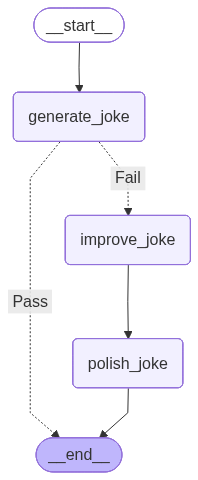

Initial joke:
Why did the math book look so sad at school?

Because it had too many problems!

--- --- ---

Improved joke:
Sure! Here’s a wordplay-enhanced version:

Why did the math book feel so *depressed* at school?

Because it couldn’t *sum* up the courage to face all its *problems*—it just couldn’t *find its x-it*!

--- --- ---

Final joke:
Absolutely! Here’s your joke with a surprising twist at the end:

Why did the math book feel so *depressed* at school?

Because it couldn’t *sum* up the courage to face all its *problems*—it just couldn’t *find its x-it*...  
And every time it tried to *divide* its feelings, things just *multiplied*!


In [28]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display


# Graph state
class State(TypedDict):
    topic: str
    joke: str
    improved_joke: str
    final_joke: str


# Nodes
def generate_joke(state: State):
    """First LLM call to generate initial joke"""

    msg = llm.invoke(f"Write a short joke about {state['topic']}")
    return {"joke": msg.content}


def check_punchline(state: State):
    """Gate function to check if the joke has a punchline"""

    # Simple check - does the joke contain "?" or "!"
    if "-" in state["joke"] or "+" in state["joke"]:
        return "Pass"
    return "Fail"


def improve_joke(state: State):
    """Second LLM call to improve the joke"""

    msg = llm.invoke(f"Make this joke funnier by adding wordplay: {state['joke']}")
    return {"improved_joke": msg.content}


def polish_joke(state: State):
    """Third LLM call for final polish"""
    msg = llm.invoke(f"Add a surprising twist to this joke: {state['improved_joke']}")
    return {"final_joke": msg.content}


# Build workflow
workflow = StateGraph(State)

# Add nodes
workflow.add_node("generate_joke", generate_joke)
workflow.add_node("improve_joke", improve_joke)
workflow.add_node("polish_joke", polish_joke)

# Add edges to connect nodes
workflow.add_edge(START, "generate_joke")
workflow.add_conditional_edges(
    "generate_joke", check_punchline, {"Fail": "improve_joke", "Pass": END}
)
workflow.add_edge("improve_joke", "polish_joke")
workflow.add_edge("polish_joke", END)

# Compile
chain = workflow.compile()

# Show workflow
display(Image(chain.get_graph().draw_mermaid_png()))

# Invoke
state = chain.invoke({"topic": "school"})
print("Initial joke:")
print(state["joke"])
print("\n--- --- ---\n")
if "improved_joke" in state:
    print("Improved joke:")
    print(state["improved_joke"])
    print("\n--- --- ---\n")

    print("Final joke:")
    print(state["final_joke"])
else:
    print("Final joke:")
    print(state["joke"])

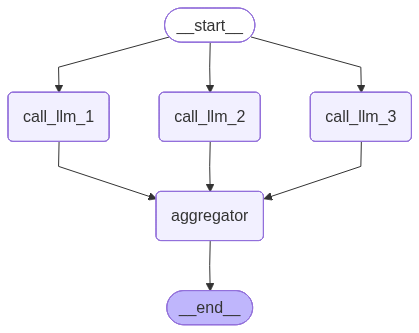

Here's a story, joke, and poem about cats!

STORY:
Once upon a time, in a little seaside village, lived three adventurous cats: Willow, Pip, and Tansy. Their owner, an old fisherman named Ewan, loved them dearly and often found himself resigned to their mischievous antics.

Every morning, the cats would leap out the window as soon as the sun tickled the rooftops. They’d race down cobblestone streets, their tails tipped like brushstrokes in the dawn, and gather at the harbor where fishing boats bobbed softly in the breeze.

Willow, elegant and clever, liked to perch atop the nets and observe the world. Pip, scrappy and brave, preferred chasing after the gulls and pestering the crabs. Tansy, round and contented, was happiest sprawled in the shade, purring as she watched the water shimmer.

One blustery day, a shrill cry echoed across the docks. A little seagull was tangled in a piece of net near the edge of the pier. Fishermen were busy mending their sails, and no one noticed. But Willow

In [29]:
# Graph state
class State(TypedDict):
    topic: str
    joke: str
    story: str
    poem: str
    combined_output: str


# Nodes
def call_llm_1(state: State):
    """First LLM call to generate initial joke"""

    msg = llm.invoke(f"Write a joke about {state['topic']}")
    return {"joke": msg.content}


def call_llm_2(state: State):
    """Second LLM call to generate story"""

    msg = llm.invoke(f"Write a story about {state['topic']}")
    return {"story": msg.content}


def call_llm_3(state: State):
    """Third LLM call to generate poem"""

    msg = llm.invoke(f"Write a poem about {state['topic']}")
    return {"poem": msg.content}


def aggregator(state: State):
    """Combine the joke, story and poem into a single output"""

    combined = f"Here's a story, joke, and poem about {state['topic']}!\n\n"
    combined += f"STORY:\n{state['story']}\n\n"
    combined += f"JOKE:\n{state['joke']}\n\n"
    combined += f"POEM:\n{state['poem']}"
    return {"combined_output": combined}


# Build workflow
parallel_builder = StateGraph(State)

# Add nodes
parallel_builder.add_node("call_llm_1", call_llm_1)
parallel_builder.add_node("call_llm_2", call_llm_2)
parallel_builder.add_node("call_llm_3", call_llm_3)
parallel_builder.add_node("aggregator", aggregator)

# Add edges to connect nodes
parallel_builder.add_edge(START, "call_llm_1")
parallel_builder.add_edge(START, "call_llm_2")
parallel_builder.add_edge(START, "call_llm_3")
parallel_builder.add_edge("call_llm_1", "aggregator")
parallel_builder.add_edge("call_llm_2", "aggregator")
parallel_builder.add_edge("call_llm_3", "aggregator")
parallel_builder.add_edge("aggregator", END)
parallel_workflow = parallel_builder.compile()

# Show workflow
display(Image(parallel_workflow.get_graph().draw_mermaid_png()))

# Invoke
state = parallel_workflow.invoke({"topic": "cats"})
print(state["combined_output"])

In [ ]:
from typing_extensions import Literal
from langchain.messages import HumanMessage, SystemMessage


# Schema for structured output to use as routing logic
class Route(BaseModel):
    step: Literal["poem", "story", "joke"] = Field(
        None, description="The next step in the routing process"
    )


# Augment the LLM with schema for structured output
router = llm.with_structured_output(Route)


# State
class State(TypedDict):
    input: str
    decision: str
    output: str


# Nodes
def llm_call_1(state: State):
    """Write a story"""

    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_2(state: State):
    """Write a joke"""

    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_3(state: State):
    """Write a poem"""

    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_router(state: State):
    """Route the input to the appropriate node"""

    # Run the augmented LLM with structured output to serve as routing logic
    decision = router.invoke(
        [
            SystemMessage(
                content="Route the input to story, joke, or poem based on the user's request."
            ),
            HumanMessage(content=state["input"]),
        ]
    )

    return {"decision": decision.step}


# Conditional edge function to route to the appropriate node
def route_decision(state: State):
    # Return the node name you want to visit next
    if state["decision"] == "story":
        return "llm_call_1"
    elif state["decision"] == "joke":
        return "llm_call_2"
    elif state["decision"] == "poem":
        return "llm_call_3"


# Build workflow
router_builder = StateGraph(State)

# Add nodes
router_builder.add_node("llm_call_1", llm_call_1)
router_builder.add_node("llm_call_2", llm_call_2)
router_builder.add_node("llm_call_3", llm_call_3)
router_builder.add_node("llm_call_router", llm_call_router)

# Add edges to connect nodes
router_builder.add_edge(START, "llm_call_router")
router_builder.add_conditional_edges(
    "llm_call_router",
    route_decision,
    {  # Name returned by route_decision : Name of next node to visit
        "llm_call_1": "llm_call_1",
        "llm_call_2": "llm_call_2",
        "llm_call_3": "llm_call_3",
    },
)
router_builder.add_edge("llm_call_1", END)
router_builder.add_edge("llm_call_2", END)
router_builder.add_edge("llm_call_3", END)

# Compile workflow
router_workflow = router_builder.compile()

# Show the workflow
display(Image(router_workflow.get_graph().draw_mermaid_png()))

# Invoke
state = router_workflow.invoke({"input": "Write me a joke about cats"})
print(state["output"])

In [ ]:
from typing import Annotated, List
import operator


# Schema for structured output to use in planning
class Section(BaseModel):
    name: str = Field(
        description="Name for this section of the report.",
    )
    description: str = Field(
        description="Brief overview of the main topics and concepts to be covered in this section.",
    )


class Sections(BaseModel):
    sections: List[Section] = Field(
        description="Sections of the report.",
    )


# Augment the LLM with schema for structured output
planner = llm.with_structured_output(Sections)